## Processing Ocean Color Imagery - Visualize Convert Images to Ocean Color

Pull in all images as modified and metadata with specific functions
    Visualize for issues and shadows and bright spots and locations
    correct for sky radiance
    visualize the distributions of both sky (clouds) and sea
    look at the variability of spectra both for specific pixels and across nearby images
    filter for orientation and location and issues

take the water leaving spectra and convert to chla as well as other future products and just intro general analysis of spectra
    produce a csv or .shp or images of ocean color products 
    

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd

import os, glob
import multiprocessing

import cv2
import numpy as np
import matplotlib.pyplot as plt

import exiftool
import datetime

import rasterio

### Helper Functions

In [3]:
import glob, os
from GPSPhoto import gpsphoto

def load_img_fn_and_meta(img_dir, count, start):
    i = 0
    j = 0
    if not count:
        count = 10000
    img_metadata = []
    imgs = []
    for file in glob.glob(img_dir + "/*.tif"):
        if j >= count:
            pass
        elif i < start:
            pass
        else:
            imgs.append(file)
            img_metadata.append(gpsphoto.getGPSData(file))
            j += 1
        i += 1
        
    return(imgs, img_metadata)

In [4]:
def load_images(img_list):
    all_imgs = []
    for im in img_list:
        with rasterio.open(im, 'r') as src:
            all_imgs.append(src.read())
    return(all_imgs)

### Primary Processing Function

In [5]:
def retrieve_imgs_and_metadata(img_dir, count=None, start=0):
    img_fns, img_metadata = load_img_fn_and_meta(img_dir, count=count, start=start)
    imgs = load_images(img_fns)
    imgs = np.array(imgs) / 32768 # this corrects it back to reflectance
    print('Output shape is: ', imgs.shape)
    return(imgs, img_metadata)

### Exploring Variability of Ocean Color Data
visualize all the band values as histograms

look into the varability of each image's bottom 5,25,10,5,1 % of values

look into the variability of the median of the sky values

look into chl variability calculated from different images based on different darkest pixels

In [6]:
sky_output = 'data/260920_shearwateroffshore_dual/skystacks'
sea_output = 'data/260920_shearwateroffshore_dual/seastacks'

sea_imgs, sea_img_metadata = retrieve_imgs_and_metadata(sea_output, count=5, start=0)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Output shape is:  (5, 6, 1471, 2022)


In [7]:
sky_imgs, sky_img_metadata = retrieve_imgs_and_metadata(sky_output, count=20)

Output shape is:  (5, 5, 946, 1271)


In [8]:
sea_imgs.nbytes / 1e9

0.71384688

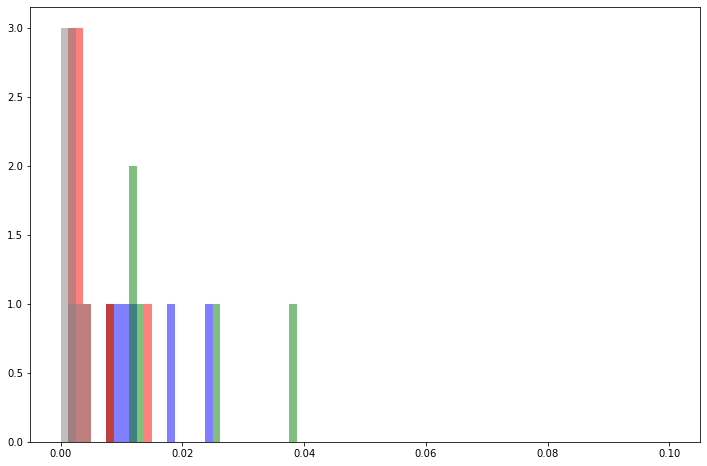

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,8))

band_names = ['blue', 'green', 'red', 'nir', 'red edge']
colors = ['blue', 'green', 'red', 'maroon', 'grey']

for i in range(0,5):
    
    ax.hist(np.mean(sea_imgs[:,i],axis=(1,2)).flatten(), range=(0,0.1), bins=80, color=colors[i], alpha=0.5)
    #ax.set_xlim(0,0.10)
    #im = ax[i].imshow(all_imgs[0,i])
    #fig.colorbar(im, ax=ax[i])

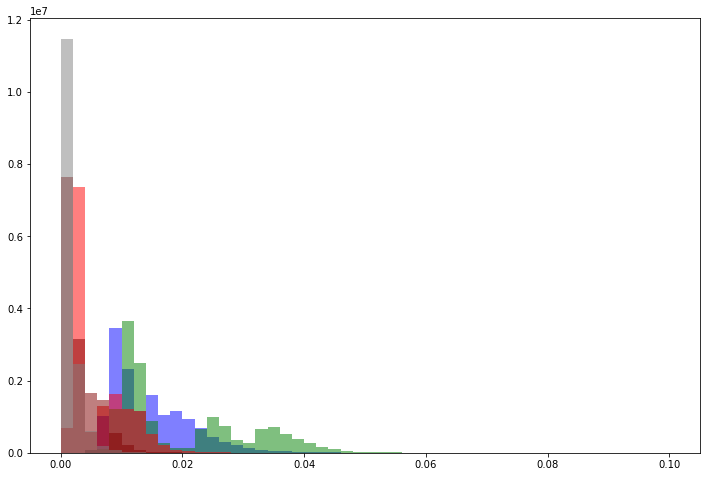

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,8))

band_names = ['blue', 'green', 'red', 'nir', 'red edge']
colors = ['blue', 'green', 'red', 'maroon', 'grey']

for i in range(0,5):
    
    ax.hist(sea_imgs[:40,i].flatten(), range=(0,0.1), bins=50, color=colors[i], alpha=0.5)
    #ax.set_xlim(0,0.10)
    #im = ax[i].imshow(all_imgs[0,i])
    #fig.colorbar(im, ax=ax[i])

(array([3.70000e+01, 7.70000e+01, 9.70000e+01, 1.26000e+02, 2.86000e+02,
        6.43000e+02, 1.48100e+03, 2.13000e+03, 4.43500e+03, 6.28400e+03,
        5.63100e+03, 1.26160e+04, 1.82520e+04, 2.64180e+04, 2.22910e+04,
        3.92330e+04, 5.32450e+04, 4.36550e+04, 7.72940e+04, 9.45200e+04,
        1.09734e+05, 8.18930e+04, 1.37798e+05, 1.58268e+05, 1.18120e+05,
        1.91578e+05, 2.06863e+05, 2.18862e+05, 1.44294e+05, 2.07883e+05,
        2.01588e+05, 1.83161e+05, 1.03413e+05, 1.32684e+05, 1.06538e+05,
        5.56150e+04, 6.06660e+04, 4.12110e+04, 3.15460e+04, 1.60120e+04,
        1.82190e+04, 1.45720e+04, 7.60400e+03, 7.51400e+03, 4.72400e+03,
        2.77500e+03, 9.69000e+02, 9.11000e+02, 4.59000e+02, 1.37000e+02]),
 array([20.51  , 20.5372, 20.5644, 20.5916, 20.6188, 20.646 , 20.6732,
        20.7004, 20.7276, 20.7548, 20.782 , 20.8092, 20.8364, 20.8636,
        20.8908, 20.918 , 20.9452, 20.9724, 20.9996, 21.0268, 21.054 ,
        21.0812, 21.1084, 21.1356, 21.1628, 21.19  , 21

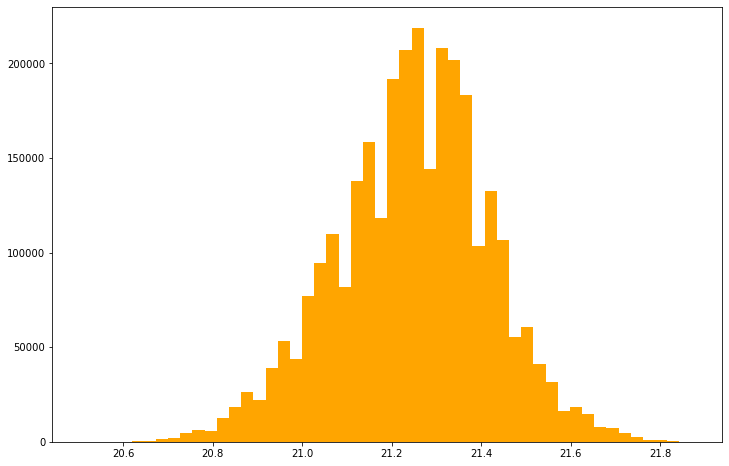

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,8))

band_names = ['thermal']
colors = ['orange']

ax.hist(sea_imgs[2,5].flatten()* 32768 / 100 - 273, bins=50, color=colors[0])

### Cut off the bright outliers

Visualize a few random images and take out the X% of brightest pixels

In [12]:
full_sea_img = sea_imgs[0]

full_sea_img.shape

(6, 1471, 2022)

In [13]:
def calculate_spectra_from_darkest_px(imgs, lowest_percent=0.65, band=4, return_imgs=False, visualize=False, sky=False):
    list_of_spectra = []
    sorted_img_list = []
    dark_idxs = []
    
    for i in range(0,imgs.shape[0]):
        if np.mean(imgs[i,0]) > 0.02 and not sky:
            continue
        # choose the percent to sort
        spectra = []
        #print(imgs.shape)
        num_to_sort = int(imgs[i,band].size * lowest_percent)
        #print('sorting ', num_to_sort)

        # efficiently sort the array
        flat_array = imgs[i,band].flatten()
        flat_array[flat_array == 0 ] = 1 # everything already equal to zero set to 1 to be ignored
        flat_array[flat_array < 0.0001 ] = 1 # take out dark pixels to be ignored
        idx = np.argpartition(flat_array, num_to_sort)[:num_to_sort]
        
        img_sorted = []
        blue_spec = None
        for img_idx in range(0,5):
            sorted_band = imgs[i,img_idx].flatten()
            if return_imgs:
                # add the sorted band to
                img_sorted.append(sorted_band)
            # take the mean of the darkest pixels from each band to add to the spectra
            spectra.append(np.mean(sorted_band[idx]))
            if img_idx == 0:
                blue_spec = np.mean(sorted_band[idx])
        if return_imgs:
            sorted_img_list.append(np.array(img_sorted))
        #if blue_spec <0.02:
        list_of_spectra.append(spectra)
        dark_idxs.append(i)
        
        if visualize:
            plt.hist(flat_array[idx], density=False)
            plt.axvline(x=np.mean(flat_array[idx]), color='red')
            plt.axvline(x=np.median(flat_array[idx]), color='black')
            print(i, np.median(flat_array[idx]))
            
    if return_imgs:
        return(sorted_img_list, idx)
    else:
        return(list_of_spectra, dark_idxs)

In [14]:
def remove_bright_pix(im, lowest_percent=0.05, band=0):

    sorted_imgs, lowest_idx = calculate_spectra_from_darkest_px(np.array([im]), lowest_percent=lowest_percent, band=0, return_imgs=True)
    
    dark_pix = np.zeros(np.array(sorted_imgs[0]).shape)
    dark_pix[:,lowest_idx] = sorted_imgs[0][:,lowest_idx]
    
    dark_pix[dark_pix < 0.0005] = 0
    dark_pix[dark_pix > 1 ] = 0
    dark_pix[dark_pix == 0] = np.nan
    
    return(dark_pix)

In [15]:
def L2chlor_a(Rrs443, Rrs488, Rrs547, Rrs555, Rrs667):
    ''' Use weighted MODIS Aqua bands to calculate chlorophyll concentration
    using oc3m blended algorithm with CI (Hu et al. 2012) '''

    thresh = [0.15, 0.20]
    a0 = 0.2424
    a1 = -2.7423
    a2 = 1.8017
    a3 = 0.0015
    a4 = -1.2280

    ci1 = -0.4909
    ci2 = 191.6590
    
    if Rrs443 > Rrs488:
        Rrsblue = Rrs443
    else:
        Rrsblue = Rrs488

    log10chl = a0 + a1 * (np.log10(Rrsblue / Rrs547)) \
        + a2 * (np.log10(Rrsblue / Rrs547))**2 \
            + a3 * (np.log10(Rrsblue / Rrs547))**3 \
                + a4 * (np.log10(Rrsblue / Rrs547))**4

    oc3m = np.power(10, log10chl)

    CI = Rrs555 - ( Rrs443 + (555 - 443)/(667 - 443) * \
        (Rrs667 -Rrs443) )
        
    ChlCI = 10** (ci1 + ci2*CI)

    if ChlCI <= thresh[0]:
        chlor_a = ChlCI
    elif ChlCI > thresh[1]:
        chlor_a = oc3m
    else:
        chlor_a = oc3m * (ChlCI-thresh[0]) / (thresh[1]-thresh[0]) +\
            ChlCI * (thresh[1]-ChlCI) / (thresh[1]-thresh[0])

    return chlor_a


In [16]:
def chla_img(sky_spectra, dark_pix, wind_speed = 5):
    dp_shape = dark_pix.shape
    sky_rad_correction = np.reshape(np.array(sky_spectra) * (0.0256 + 0.00039 * wind_speed + 0.000034 * wind_speed * wind_speed), (5,1))
    water_leaving = dark_pix.reshape(5,-1) - sky_rad_correction
    
    chlas = []
    for i in range(water_leaving.shape[-1]):
        chlas.append(L2chlor_a(water_leaving[0,i],water_leaving[0,i],water_leaving[1,i],water_leaving[1,i],water_leaving[2,i]))
    chlas = np.array(chlas)
    return(chlas.reshape(dp_shape[1:3]))

In [17]:
def visualize_chla_across_thresholds(im, sky_spectra):
    thresholds = np.arange(0.1,1,0.1)
    fig, ax = plt.subplots(len(thresholds),1, figsize=(12,40))
    for i,lowest_percent in enumerate(thresholds):
        dark_pix = remove_bright_pix(im, lowest_percent=lowest_percent, band=0)
        full_chla_img = chla_img(sky_spectra, dark_pix.reshape(im.shape), wind_speed = 5)
        
        ims = ax[i].imshow(full_chla_img, interpolation='nearest', cmap='jet', vmax=0.5)
        ax[i].set_title(lowest_percent)
        #current_cmap = matplotlib.cm.get_cmap()
        #current_cmap.set_bad(color='yellow')
        fig.colorbar(ims, ax=ax[i], fraction=0.046, pad=0.04)

In [18]:
def visualize_darkest_pixels(im, lowest_percent=0.5, only_img=False):
    if im.shape[0] == 6: # because these are altum images
        im_flat = im[:-1].reshape(5,-1)
    else:
        im_flat = im.reshape(5,-1)
    # sort to get the darkest x pixels
    
    # visualize all bands and an RGB composite
    

    band_names = ['blue', 'green', 'red', 'nir', 'red edge']
    colors = ['blue', 'green', 'red', 'maroon', 'grey']
    
    fig, ax = plt.subplots(1,5, figsize=(16,14))
    for i,a in enumerate(ax):
        ims = a.imshow(im[i], cmap='jet', vmax=0.02, vmin=0)
        a.set_title(band_names[i])
        fig.colorbar(ims, ax=a, fraction=0.046, pad=0.04)
        a.set_xticks([])
        a.set_yticks([])
#     ims = ax[5].imshow(im[0]/im[1], cmap='jet', vmax=10, vmin=0)
#     ax[5].set_title('blue/green')
#     ax[5].set_xticks([])
#     ax[5].set_yticks([])
#     fig.colorbar(ims, ax=ax[5], fraction=0.046, pad=0.04)
    #plt.savefig('openoceanfull.png')
    fig.show()
        
    if not only_img:
        
        # visualize all bands with the darkest pixels removed
        dark_pix = remove_bright_pix(im, lowest_percent=lowest_percent, band=0)


        fig, ax = plt.subplots(1,5, figsize=(16,14))
        for i,a in enumerate(ax):
            ims = a.imshow(dark_pix[i].reshape(im.shape[1:3]), interpolation='none', cmap='jet', vmax=0.2, vmin=0)
            a.set_title(band_names[i])
            fig.colorbar(ims, ax=a, fraction=0.046, pad=0.04)
            a.set_xticks([])
            a.set_yticks([])
        #plt.savefig('openoceanfilter.png')
        fig.show()


        fig, ax = plt.subplots(figsize=(12,8))
        colors = ['blue', 'green', 'red', 'grey', 'black']
        for i in range(0,5):
            ax.hist(dark_pix[i].flatten(), density=True, bins=50, color=colors[i], alpha=0.5)

        for i in range(0,5):
            print(np.count_nonzero(~np.isnan(dark_pix[i])))
        ax.set_xlim(0,0.1)

        return(dark_pix.reshape(5,im.shape[1], im.shape[2]))
    else:
        return(None)

In [19]:
sea_imgs[1].shape

(6, 1471, 2022)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


1041026
1041026
1039863
1038011
659429


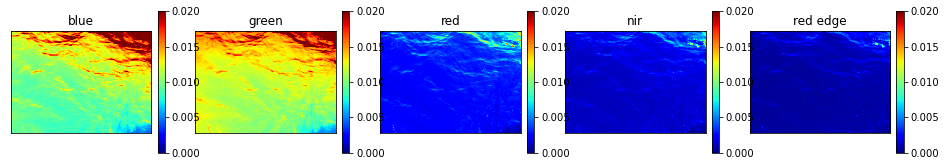

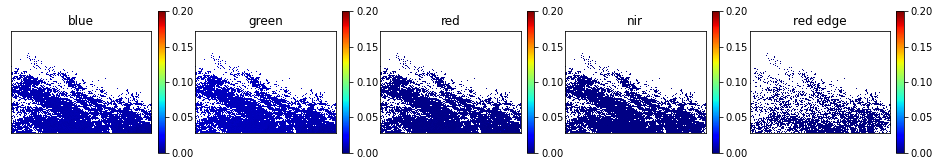

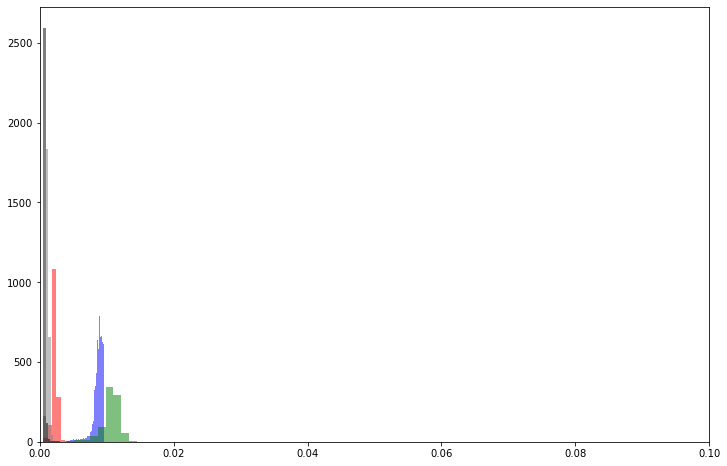

In [20]:
lowest_percent = 0.35
dark_pix_dark = visualize_darkest_pixels(sea_imgs[-1], lowest_percent=lowest_percent)

In [21]:
np.nanmean(dark_pix_dark,axis=(1,2))

array([0.00874628, 0.01065021, 0.00225269, 0.00117494, 0.00066449])

In [22]:
np.nanmean(dark_pix_dark,axis=(1,2))

array([0.00874628, 0.01065021, 0.00225269, 0.00117494, 0.00066449])

In [23]:
np.mean(sea_imgs[20],axis=(1,2))

IndexError: index 20 is out of bounds for axis 0 with size 5

In [ ]:
np.mean(sea_imgs[27],axis=(1,2))

In [ ]:
for i in range(0,5):
    visualize_darkest_pixels(sea_imgs[i], only_img=True)

Calculate spectra based on that brightness threshold

In [24]:
len(sea_spectra)

NameError: name 'sea_spectra' is not defined

0 0.007720947265625
1 0.0087890625
2 0.014923095703125
4 0.0089111328125


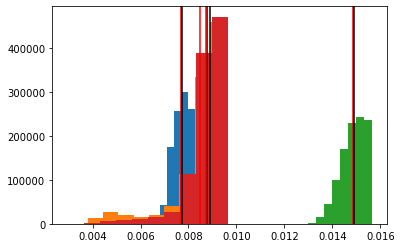

In [24]:
lowest_percent = .35

sea_spectra, sea_idxs = calculate_spectra_from_darkest_px(sea_imgs, lowest_percent=lowest_percent, band=0, visualize=True)

In [25]:
#remove outliers as necessary
#del sea_spectra[162]
#del sea_img_metadata[162]

0 0.035186767578125
1 0.10906982421875
2 0.029541015625
3 0.02947998046875
4 0.02911376953125


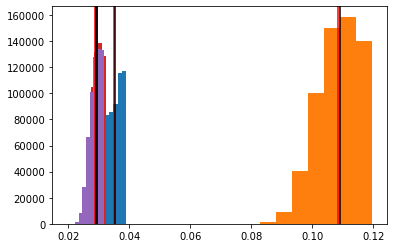

In [26]:
lowest_percent = .5

sky_spectra = calculate_spectra_from_darkest_px(sky_imgs, lowest_percent=lowest_percent, band=4, visualize=True, sky=True)

In [27]:
sea_imgs[0,:-1].shape

(5, 1471, 2022)

In [28]:
#visualize_chla_across_thresholds(sea_imgs[0,:-1], sky_spectra)

In [29]:
sky_spectra[0]

[[0.11167494870692711,
  0.07659087192663583,
  0.04086011668949102,
  0.0322514877717695,
  0.03488065690311332],
 [0.20715475069944775,
  0.20132367368536286,
  0.1345678198662217,
  0.09056162470065206,
  0.10854960830346362],
 [0.11091048571758724,
  0.07510929841597214,
  0.03824689171768933,
  0.029030204739940876,
  0.02941997579213089],
 [0.10976459891640537,
  0.07439948023858207,
  0.03872315803205604,
  0.028561930886506402,
  0.029286545330044836],
 [0.10613909375153344,
  0.07205405514571764,
  0.03763231620395355,
  0.027892011205260477,
  0.028896371984698424]]

Inspect variability of spectra

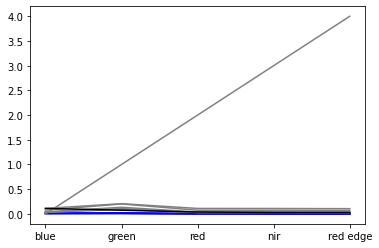

In [30]:
band_names = ['blue', 'green', 'red', 'nir', 'red edge']
for spectra in sea_spectra:
    plt.plot(band_names, spectra, color='blue')
    
for spectra in sky_spectra:
    plt.plot(band_names, spectra, color='grey')
plt.plot(np.median(sky_spectra[0], axis=0), color='black')

### Correct for sun glint

TODO currently just averaging sky spectra for removal but could easily interpolate across and incorporate time into which is chosen

In [31]:
def sun_glint_removal(sea_spectra, sky_spectra, wind_speed, method='ruddick2006'):
    sky_spectra = np.median(sky_spectra,axis=0)
    water_leaving_spectra = []
    # TODO will add in Zhang and other approaches
    if method == 'ruddick2006':
        for water_spec in sea_spectra:
            water_leaving = np.array(water_spec) - np.array(sky_spectra) * (0.0256 + 0.00039 * wind_speed + 0.000034 * wind_speed * wind_speed)
            water_leaving_spectra.append(water_leaving)
    return(water_leaving_spectra)

In [32]:
# TODO will pull this from the ship CSV in practice
wind_speed = 5
water_leaving_spec = sun_glint_removal(sea_spectra, sky_spectra[0], wind_speed=wind_speed)

#### Inspect the output from the removal

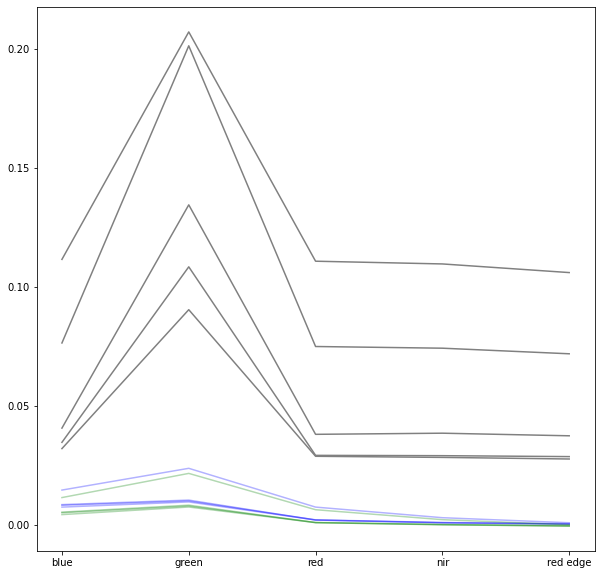

In [33]:
fig, ax = plt.subplots(figsize=(10,10))

for spectra in sea_spectra:
    ax.plot(band_names, spectra, color='blue', alpha=0.3)
    
for spectra in water_leaving_spec:
    ax.plot(band_names, spectra, color='green', alpha=0.3)
    
ax.plot(band_names, np.array(sky_spectra[0]), color='grey')
#ax.plot(seaimgset.captures[capture_num].band_names_lower(), [0.13079345, 0.08020303, 0.05103283, 0.04054285, 0.04573154])

### Chlorophyll retrieval algorithm

TODO will need to modify the coefficients of this algorithm if possible
TODO will need to interpolate the spectra from the senop into the right band widths for this algorithm at this step

Run chla retrieval on water leaving spectra

In [34]:
chla_list = []
for spectra in water_leaving_spec:
    chla = L2chlor_a(spectra[0],spectra[0],spectra[1],spectra[1],spectra[2])
    chla_list.append(chla)

In [35]:
chla_list

[9.299100744248733, 6.4855480017347436, 12.936102359975061, 6.325684646362254]

### Save spectra and chla values as a geopandas dataframe along with image metadata

In [36]:
# TODO need to filter out for bad lat and lon and bad chl values
# it seems like sometimes lat and long are 0

In [37]:
from datetime import datetime
import pandas as pd

def convert_to_ocean_color_gdf(chla_list, spectra_list, img_metadata):
    chla_dates = []
    for im in img_metadata:
        date_time_str = im['Date'] + ' ' + im['UTC-Time']

        date_time_obj = datetime.strptime(date_time_str, '%m/%d/%Y %H:%M:%S')
        chla_dates.append(date_time_obj)
    lons = []
    lats = []
    for im in img_metadata:
        lons.append(im['Longitude'])
        lats.append(im['Latitude'])
        
        
    chla_df = pd.DataFrame(
    {'chla': chla_list,
     'Latitude': lats,
     'Longitude': lons,
     'spectra' : spectra_list,
     'time' : chla_dates})

    chla_gdf = gpd.GeoDataFrame(
        chla_df, geometry=gpd.points_from_xy(chla_df.Longitude, chla_df.Latitude))
    
    return(chla_gdf)

In [38]:
gdf = convert_to_ocean_color_gdf(chla_list, water_leaving_spec, [sea_img_metadata[i] for i in sea_idxs])

gdf.head()

,chla,Latitude,Longitude,spectra,time,geometry
0,9.299101,34.538931,-76.533789,"[0.004544974552103778, 0.0077359843931422215, ...",2020-09-26 15:42:41,POINT (-76.53379 34.53893)
1,6.485548,34.517408,-76.526608,"[0.005316165388753451, 0.008150649086718482, 0...",2020-09-26 15:38:26,POINT (-76.52661 34.51741)
2,12.936102,34.602500,-76.553319,"[0.011702465953427749, 0.02184922779572392, 0....",2020-09-26 15:54:35,POINT (-76.55332 34.60250)
3,6.325685,34.475156,-76.512294,"[0.005596422885277239, 0.008517108790500948, 0...",2020-09-26 15:29:51,POINT (-76.51229 34.47516)


<AxesSubplot:>

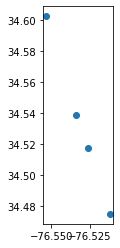

In [39]:
gdf.plot()

<AxesSubplot:>

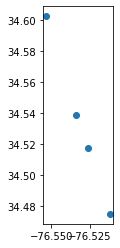

In [40]:
gdf = gdf.drop(gdf[gdf.Latitude == 0].index)
gdf.plot()

Save out the file

In [41]:
gdf.time = gdf.time.astype(str)
gdf.spectra = gdf.spectra.astype(str)
#gdf.to_file('data/260920_shearwateroffshore_dual/uas_data_260920_1_dark.shp')

### Inspect Full Images

In [42]:
sky_spectra[0][0]

[0.11167494870692711,
 0.07659087192663583,
 0.04086011668949102,
 0.0322514877717695,
 0.03488065690311332]

In [43]:
full_img_chla = chla_img(sky_spectra[0][0], dark_pix_dark)
np.nanmax(full_img_chla), np.nanmedian(full_img_chla), np.nanmean(full_img_chla)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10


(4362.521132194457, 6.300339826834442, 7.527939916368208)

In [44]:
dark_pix_dark.shape

(5, 1471, 2022)

In [45]:
full_img_chla.shape

(1471, 2022)

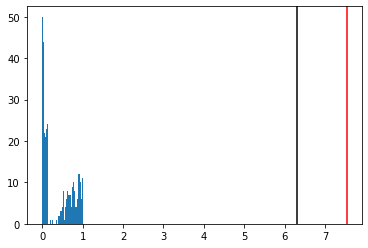

In [46]:
plt.hist(full_img_chla.flatten(), range=(0,1), bins=60)
plt.axvline(np.nanmedian(full_img_chla), c='black')
plt.axvline(np.nanmean(full_img_chla), c='red')
plt.show()

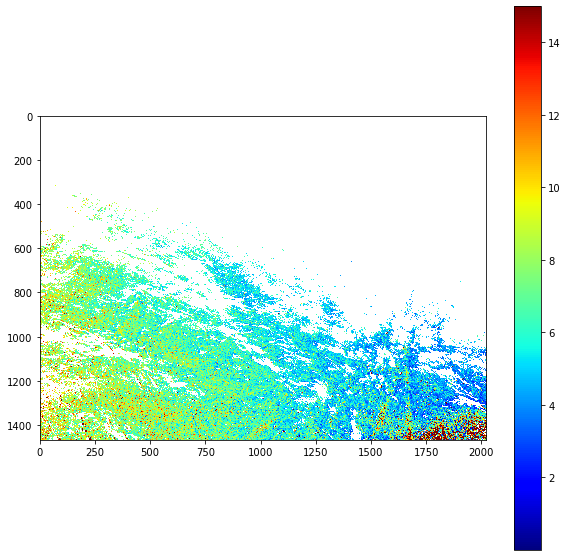

In [47]:
import matplotlib
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(full_img_chla, interpolation='nearest', cmap='jet', vmax=15)
#current_cmap = matplotlib.cm.get_cmap()
#current_cmap.set_bad(color='yellow')

fig.colorbar(im)

In [48]:
sea_img_metadata[-1]

{'Latitude': 34.47515555555556,
 'Longitude': -76.51229444444445,
 'Altitude': 10.1,
 'UTC-Time': '15:29:51',
 'Date': '09/26/2020'}

In [ ]:
### need to read in all the exifdata from the image to get heading and everything else

### then determine the correct transformation based on all that data

### then write the transformed image into a geotiff

In [214]:
import exifread
# Open image file for reading (binary mode)
path_name = 'data/260920_shearwateroffshore_dual/sea/IMG_0473_1.tif'
f = open(path_name, 'rb')

# Return Exif tags
tags = exifread.process_file(f)
tags

{'Image SubfileType': (0x00FE) Long=Full-resolution Image @ 6381806,
 'Image ImageWidth': (0x0100) Long=2064 @ 6381818,
 'Image ImageLength': (0x0101) Long=1544 @ 6381830,
 'Image BitsPerSample': (0x0102) Short=16 @ 6381842,
 'Image Compression': (0x0103) Short=Uncompressed @ 6381854,
 'Image PhotometricInterpretation': (0x0106) Short=1 @ 6381866,
 'Image Make': (0x010F) ASCII=MicaSense @ 6374086,
 'Image Model': (0x0110) ASCII=Altum @ 6374096,
 'Image StripOffsets': (0x0111) Long=[8, 412808, 825608, 1238408, 1651208, 2064008, 2476808, 2889608, 3302408, 3715208, 4128008, 4540808, 4953608, 5366408, 5779208, 6192008] @ 6374102,
 'Image Orientation': (0x0112) Short=Horizontal (normal) @ 6381914,
 'Image SamplesPerPixel': (0x0115) Short=1 @ 6381926,
 'Image RowsPerStrip': (0x0116) Short=100 @ 6381938,
 'Image StripByteCounts': (0x0117) Long=[412800, 412800, 412800, 412800, 412800, 412800, 412800, 412800, 412800, 412800, 412800, 412800, 412800, 412800, 412800, 181632] @ 6374166,
 'Image Pla

Worth noting that this notebook https://github.com/micasense/imageprocessing/blob/e3744671c521056de46c3d05c3e9446a971662c9/MicaSense%20Image%20Processing%20Tutorial%203.ipynb has this caveat about the sensor:
        
An onboard orientation sensor provides a fairly rough version of the earth-fixed orientation of the DLS. The quality of this orientation varies based on the quality of the sensor installation and calibration, but in even the best cases it has a few degrees of error.

In [215]:
import os
import micasense.image as image
img = image.Image(path_name)

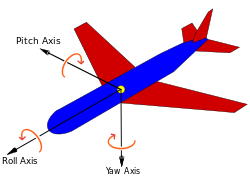

In [216]:
import math
# this fcn returns (yaw,pitch,roll) tuples in radians of the earth-fixed dls pose
yaw, pitch, roll = np.array([img.dls_yaw, img.dls_pitch, img.dls_roll]) * 180/math.pi # convert this to degrees from rads for cameratransform
yaw, pitch, roll

(99.04385461020307, 4.440835040198486, -0.16400756507190928)

In [218]:
sensor_offset = 40

In [219]:
import cameratransform as ct

# intrinsic camera parameters
f = img.focal_length # returns focal length in mm
# dividing the pixel size by the focal plane resolution in mm to get sensor size - px/(px/mm) leaves mm
sensor_size = img.size()[0] / img.focal_plane_resolution_px_per_mm[0], img.size()[1] / img.focal_plane_resolution_px_per_mm[1]    # in mm
image_size = img.size()    # in px

cam = ct.Camera(ct.RectilinearProjection(focallength_mm=f,
                                         sensor=sensor_size,
                                         image=image_size),
               ct.SpatialOrientation(elevation_m=img.altitude,
                                     tilt_deg=pitch+sensor_offset,
                                     roll_deg=roll,
                                    heading_deg=-yaw))

# gps pts are lat lon
cam.setGPSpos(img.latitude, img.longitude, img.altitude)

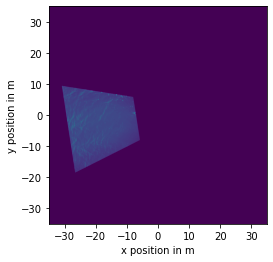

In [223]:
%matplotlib inline
import matplotlib.pyplot as plt
# display a top view of the image
im = plt.imread(path_name)
top_im = cam.getTopViewOfImage(im, [-35, 35,-35, 35], do_plot=True)
#top_im = cam.getTopViewOfImage(im, do_plot=True)
plt.xlabel("x position in m")
plt.ylabel("y position in m");

In [224]:
top_im.shape

(1786, 1786)

In [225]:
top_im_float = top_im.astype(np.float)

In [226]:
top_im_float[top_im_float == 0] = np.nan

(array([1.38324e+05, 1.58970e+05, 5.32200e+03, 3.60000e+02, 7.10000e+01,
        3.90000e+01, 3.20000e+01, 2.40000e+01, 1.20000e+01, 1.62000e+02]),
 array([ 7440. , 13246.4, 19052.8, 24859.2, 30665.6, 36472. , 42278.4,
        48084.8, 53891.2, 59697.6, 65504. ]),
 <BarContainer object of 10 artists>)

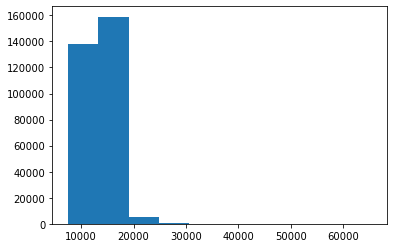

In [281]:
plt.hist(top_im_float.flatten())

(600.0, 1400.0)

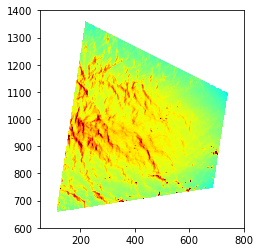

In [287]:
plt.imshow(top_im_float, cmap='jet', clim=(0,22000))
plt.xlim(50,800)
plt.ylim(600,1400)

In [230]:
?rasterio.transform.from_gcps

In [231]:
coords = np.array([cam.gpsFromImage([0 , 0]), \
cam.gpsFromImage([image_size[0]-1 , 0]), \
cam.gpsFromImage([image_size[0]-1, image_size[1]-1]), \
cam.gpsFromImage([0 , image_size[1]-1])])

In [232]:
coords

array([[ 34.63837532, -76.54596853,   0.        ],
       [ 34.6386256 , -76.54601507,   0.        ],
       [ 34.63859374, -76.54576512,   0.        ],
       [ 34.63846925, -76.5457415 ,   0.        ]])

In [236]:
gcp1 = rasterio.control.GroundControlPoint(row=0, col=0, x=coords[0,1], y=coords[0,0], z=coords[0,2], id=None, info=None)
gcp2 = rasterio.control.GroundControlPoint(row=image_size[0]-1, col=0, x=coords[1,1], y=coords[1,0], z=coords[1,2], id=None, info=None)
gcp3 = rasterio.control.GroundControlPoint(row=image_size[0]-1, col=image_size[1]-1, x=coords[2,1], y=coords[2,0], z=coords[2,2], id=None, info=None)
gcp4 = rasterio.control.GroundControlPoint(row=0, col=image_size[1]-1, x=coords[3,1], y=coords[3,0], z=coords[3,2], id=None, info=None)

In [237]:
[gcp1,gcp2,gcp3,gcp4]

[GroundControlPoint(row=0, col=0, x=-76.54596852912796, y=34.638375318263705, z=0.0, id='fcf217c3-0f60-4dd6-9353-28d0cd75ab9d'),
 GroundControlPoint(row=2063, col=0, x=-76.54601506834648, y=34.63862559613679, z=0.0, id='8474f806-0af9-4b19-87f5-8b692bbd545d'),
 GroundControlPoint(row=2063, col=1543, x=-76.54576511996795, y=34.638593742549496, z=0.0, id='2d62fed9-1e3c-4a2b-b7ad-9fc95f2c1bb7'),
 GroundControlPoint(row=0, col=1543, x=-76.54574150110057, y=34.638469248845425, z=0.0, id='57da1bd1-b91e-4621-bb07-75fe546d8e10')]

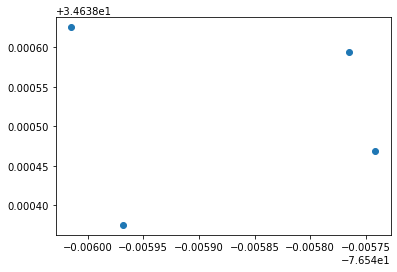

In [238]:
plt.scatter(coords[:,1], coords[:,0])

In [ ]:
with rasterio.open('RGB.byte.tif') as source:
    print(source.rpcs)
    src_crs = "EPSG:4326"  # This is the crs of the rpcs

    # Destination: a 1024 x 1024 dataset in Web Mercator (EPSG:3857)
    destination = np.zeros((1024, 1024), dtype=np.uint8)
    dst_crs = "EPSG:3857"

    _, dst_transform = reproject(
        source,
        destination,
        rpcs=source.rpcs,
        src_crs=src_crs,
        dst_crs=dst_crs,
        resampling=Resampling.nearest,
        **kwargs
    )

In [259]:
tsfm = rasterio.warp.calculate_default_transform(rasterio.crs.CRS({"init": "epsg:4326"}), rasterio.crs.CRS({"init": "epsg:4326"}), img.size()[0], img.size()[1], left=None, bottom=None, right=None, top=None, gcps=[gcp1,gcp2,gcp3,gcp4], resolution=None, dst_width=None, dst_height=None)
tsfm[0]

Affine(1.3368868686359768e-07, 0.0, -76.54600051323528,
       0.0, -1.3368868686359768e-07, 34.63858852721188)

In [239]:
n = np.max(coords[:,0]) # max latitude aka north
s = np.min(coords[:,0]) # min lat aka south
w = np.max(coords[:,1]) # max lon aka west
e = np.min(coords[:,1]) # min lon aka east

In [303]:
import rasterio
# Register GDAL format drivers and configuration options with a
# context manager.
with rasterio.Env():
    
    # open the original image to get some of the basic metadata
    with rasterio.open(path_name, 'r') as src:
        profile = src.profile
        
    print(profile)
        
    # pull in altitude and calculate the pixel size from sea_img_metadata
    pix_size = .1 # equal to altitude snesor size and focal length
    heading=0 # yaw in radians

    # pull in lat/lon

    # calculate the bounds from the headings and center location (and the tilt of the sensor)
    

    # create rasterio transform
    #tsfm = rasterio.transform.from_bounds(w, s, e, n, img.size()[0], img.size()[1])
    #tsfm = rasterio.transform.from_gcps([gcp1,gcp2,gcp3,gcp4])
    #tsfm = rasterio.transform.from_origin(lon, lat, 0.1, 0.1)
    tsfm = rasterio.warp.calculate_default_transform(rasterio.crs.CRS({"init": "epsg:4326"}), rasterio.crs.CRS({"init": "epsg:4326"}), img.size()[0], img.size()[1], left=None, bottom=None, right=None, top=None, gcps=[gcp1,gcp2,gcp3,gcp4], resolution=None, dst_width=None, dst_height=None)
    tsfm = tsfm[0]
    print(tsfm)
    crs = rasterio.crs.CRS({"init": "epsg:4326"})

    # And then change the band count to 1, set the
    # dtype to uint8, and specify LZW compression.
    profile.update(
        dtype=rasterio.uint8,
        transform = tsfm,
        crs=crs)
    
    print(profile)

    with rasterio.open('example3.tif', 'w', **profile) as dst:
        dst.write(im.astype(rasterio.uint8), 1)

# At the end of the ``with rasterio.Env()`` block, context
# manager exits and all drivers are de-registered.

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 2064, 'height': 1544, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False, 'interleave': 'band'}
| 0.00, 0.00,-76.55|
| 0.00,-0.00, 34.64|
| 0.00, 0.00, 1.00|
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 2064, 'height': 1544, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(1.3368868686359768e-07, 0.0, -76.54600051323528,
       0.0, -1.3368868686359768e-07, 34.63858852721188), 'tiled': False, 'interleave': 'band'}


In [304]:
print(profile)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 2064, 'height': 1544, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(1.3368868686359768e-07, 0.0, -76.54600051323528,
       0.0, -1.3368868686359768e-07, 34.63858852721188), 'tiled': False, 'interleave': 'band'}


(array([195920.,      0.,      0., 201471.,      0.,      0., 198268.,
             0.,      0.,      0., 200633.,      0.,      0., 196600.,
             0.,      0., 200677.,      0.,      0.,      0., 197562.,
             0.,      0., 200759.,      0.,      0., 196142.,      0.,
             0.,      0., 201374.,      0.,      0., 198913.,      0.,
             0., 201610.,      0.,      0.,      0., 196287.,      0.,
             0., 198199.,      0.,      0., 201125.,      0.,      0.,
        201276.]),
 array([  0. ,   4.8,   9.6,  14.4,  19.2,  24. ,  28.8,  33.6,  38.4,
         43.2,  48. ,  52.8,  57.6,  62.4,  67.2,  72. ,  76.8,  81.6,
         86.4,  91.2,  96. , 100.8, 105.6, 110.4, 115.2, 120. , 124.8,
        129.6, 134.4, 139.2, 144. , 148.8, 153.6, 158.4, 163.2, 168. ,
        172.8, 177.6, 182.4, 187.2, 192. , 196.8, 201.6, 206.4, 211.2,
        216. , 220.8, 225.6, 230.4, 235.2, 240. ]),
 <BarContainer object of 50 artists>)

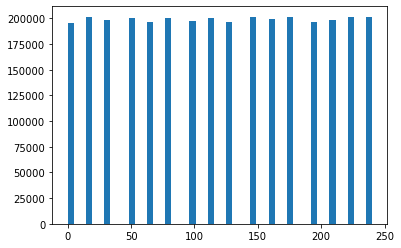

In [308]:
plt.hist(src.read().flatten(),bins=50)

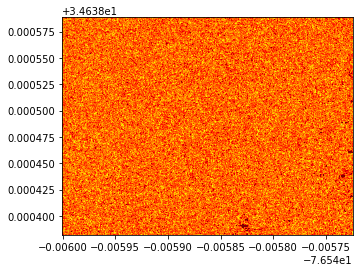

<AxesSubplot:>

In [313]:
from rasterio.plot import show
src = rasterio.open("example3.tif")
show(src,clim=(0,150),cmap='jet')

In [ ]:
gcp1 = rasterio.control.GroundControlPoint(row=0, col=0, x=coords[0,1], y=coords[0,0], z=coords[0,2], id=None, info=None)
gcp2 = rasterio.control.GroundControlPoint(row=image_size[0]-1, col=0, x=coords[1,1], y=coords[1,0], z=coords[1,2], id=None, info=None)
gcp3 = rasterio.control.GroundControlPoint(row=image_size[0]-1, col=image_size[1]-1, x=coords[2,1], y=coords[2,0], z=coords[2,2], id=None, info=None)
gcp4 = rasterio.control.GroundControlPoint(row=0, col=image_size[1]-1, x=coords[3,1], y=coords[3,0], z=coords[3,2], id=None, info=None)

In [317]:
import shutil
from osgeo import gdal, osr

orig_fn = 'example.tif'
output_fn = 'output2.tif'

# Create a copy of the original file and save it as the output filename:
shutil.copy(orig_fn, output_fn)
# Open the output file for writing for writing:
ds = gdal.Open(output_fn, gdal.GA_Update)
# Set spatial reference:
sr = osr.SpatialReference()
sr.ImportFromEPSG(4326) #2193 refers to the NZTM2000, but can use any desired projection

# Enter the GCPs
#   Format: [map x-coordinate(longitude)], [map y-coordinate (latitude)], [elevation],
#   [image column index(x)], [image row index (y)]
gcps = [gdal.GCP(coords[0,0], coords[0,1], 0, 0, 0),
        gdal.GCP(coords[1,0], coords[1,1], 0, 0, image_size[0]-1),
        gdal.GCP(coords[2,0], coords[2,1], 0, image_size[1]-1, image_size[0]-1),
        gdal.GCP(coords[3,0], coords[3,1], 0, image_size[1]-1, 0)]

# Apply the GCPs to the open output file:
ds.SetGCPs(gcps, sr.ExportToWkt())

# Close the output file in order to be able to work with it in other programs:
ds = None

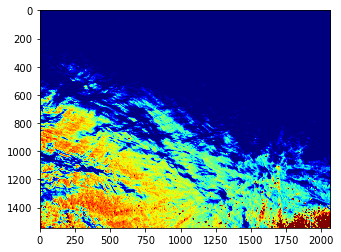

<AxesSubplot:>

In [324]:
from rasterio.plot import show
src = rasterio.open("output2.tif")
show(src,clim=(0,10),cmap='jet')

In [319]:
import rioxarray
ds5 = rioxarray.open_rasterio("output2.tif")
ds5

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/rioxarray/_io.py:678: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))


<xarray.DataArray (band: 1, y: 1544, x: 2064)>
[3186816 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 1.542e+03 1.542e+03 1.544e+03
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 2.062e+03 2.062e+03 2.064e+03
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref